# 1. Исследовательский анализ данных

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Датасет явно большой, а значит при подготовке модели "замораживать" ResNet не нужно: переобучения не ожидаю.

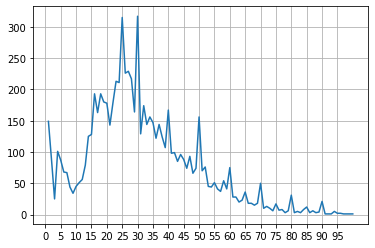

In [17]:
# Постройте график распределения возраста в выборке
labels_dist = labels.groupby('real_age')['real_age'].count()
plt.grid(True)
plt.xticks(range(0, 100, 5))
plt.plot(labels_dist)
plt.show()

* Видим заметные тики в возрастах кратных 10. Вероятно для части датасета был указан не точный возраст, а промежуток (типа 50-60).
* Если сгладить тики, то есть размазать их по ближайшим годам, то визуально график напоминает пуассоновское распределение.
* В датасете больше всего фотографий людей среднего возраста (25-30 лет). Разумеется в реальной жизни, это не так: детей должно быть больше всего, а далее количество людей с возрастом уменьшается. Но это можно объяснить, например, тем, что модель планируется пременять в определенной среде, в которой превалирует средний возраст.

Found 7591 validated image filenames.


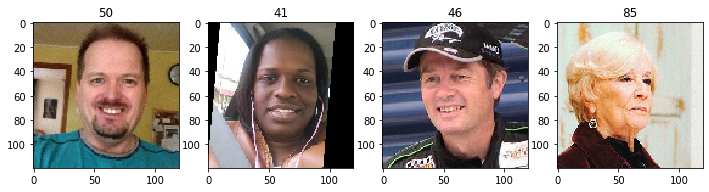

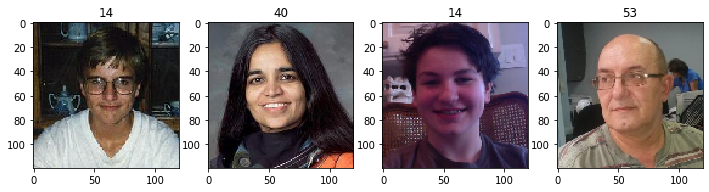

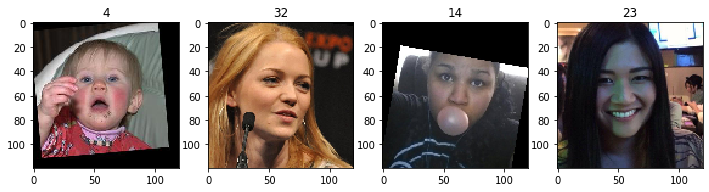

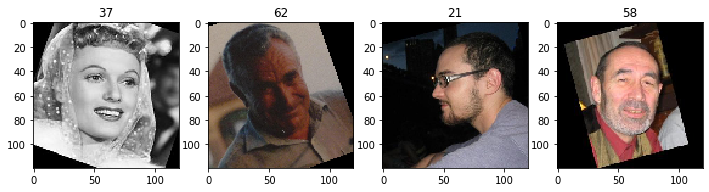

In [19]:
# Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(120, 120),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

x, y = next(datagen_flow)

# Тут я в 4 ряда печатаю 16 картинок из next(datagen_flow)
# Я хочу, чтобы к каждой из картинок был подписан реальный возраст (см. ниже set_title)
for i in range(4):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for j in range(4):
        axes[j].imshow(x[4 * i + j])
        axes[j].set_title(y[4 * i + j])

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

LABELS = pd.read_csv('/datasets/faces/labels.csv')


def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    datagen_flow = datagen.flow_from_dataframe(
        dataframe=LABELS,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return datagen_flow

def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    datagen_flow = datagen.flow_from_dataframe(
        dataframe=LABELS,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return datagen_flow

def create_model(input_shape):
    model = Sequential()
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=16, epochs=5, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=None, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)

    return model

```

```

Epoch 1/5
356/356 - 117s - loss: 203.5028 - mae: 10.3843 - val_loss: 485.2190 - val_mae: 16.9072
Epoch 2/5
356/356 - 42s - loss: 67.6374 - mae: 6.2855 - val_loss: 147.8227 - val_mae: 9.7653
Epoch 3/5
356/356 - 42s - loss: 37.1155 - mae: 4.7068 - val_loss: 86.7829 - val_mae: 7.0565
Epoch 4/5
356/356 - 42s - loss: 23.9718 - mae: 3.8150 - val_loss: 72.9172 - val_mae: 6.4520
Epoch 5/5
356/356 - 42s - loss: 18.5275 - mae: 3.2854 - val_loss: 106.7112 - val_mae: 7.7753
Test MAE: 7.7753

```

# 3. Анализ обученной модели

Мы подготовили модель для определения возраста по фотографии на базе архитектуры ResNet50.

В итоге на тестовой выборке MAE достиг значения 7.77, то есть модель ошибается примерно на 8 лет.